Import libraries

In [1]:
import os
import time
import json
import scipy as sp
import numpy as np
import pandas as pd
import tushare as ts
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# ingore warning
warnings.filterwarnings("ignore")  

from turtle import color
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.ar_model import AutoReg

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, f_regression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVR, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist, squareform

### Define function for modelling

In [4]:
def autoregression_model_pipeline(dataset, test_size, predict_size, lag_value):
	''' Create and evaluate an updated autoregressive model and predict value in future

	Args: 
		dataset: one row/column dataframe with train data
		test_size: the number of test dataset size
		predict_size: the number of predict dataset size
		lag_value: selected lag value
	Returns: 
		a list of prediction values
	
	'''
	# split to train and test dataset
	X = dataset.values
	train, test = X[1:len(X)-test_size], X[len(X)-predict_size:]

	# train autoregression
	window = lag_value
	model = AutoReg(train, lags=lag_value)
	model_fit = model.fit()
	coef = model_fit.params

	# walk forward over time steps in test
	history = train[len(train)-window:]
	history = [history[i] for i in range(len(history))]
	predictions = list()

	# train and predict value at next time steps
	for t in range(len(test)):
		length = len(history)
		lag = [history[i] for i in range(length-window,length)]
		yhat = coef[0]

		# predict yhat
		for d in range(window):
			yhat += coef[d+1] * lag[window-d-1]

		# store the prediction result and the history value
		obs = test[t]
		predictions.append(yhat)
		history.append(obs)

		# compare the value difference when training the model 
		if test_size != 0:
			print('predicted=%f, expected=%f' % (yhat, obs))
	
	# calculate the RMSE for model performance
	if test_size != 0:
		rmse = np.sqrt(mean_squared_error(test, predictions))
		print('Test RMSE: %.3f' % rmse)

		# generate plot
		num = [i for i in range(1, test_size+1)]
		fig, ax = plt.subplots(figsize = (10,6))
		plt.plot(num, test, color='darkred', label='Actual')
		plt.plot(num, predictions, color='coral', label='Predict')
		plt.xlabel('Timeline')
		plt.xticks(rotation=90)
		plt.legend()
		plt.tight_layout()
		plt.show()
	
	# return the result of prediction
	return predictions

In [16]:
def linear_model_function(x_train, y_train, x_predict):
    ''' Fit a simple linear regression OLS and predict value

	Args: 
		x_train: a list contains x train value
        y_train: a list contains y train value
        x_predict: x value for predicting
	Returns: 
		a dataframe contains all train values and prediction values
	
	'''
    # conver the list to dataframe
    train_df = pd.DataFrame()
    predict_df = pd.DataFrame()
    train_df['X'] = x_train
    train_df['Y'] = y_train
    predict_df['X'] = x_predict

    # fit ols model
    linear_model = sm.formula.ols('Y ~ X', data = train_df).fit()
    print(linear_model.summary())

    # model prediction
    y_predict = linear_model.predict(exog=predict_df['X'], transform=True)
    predict_df['Y'] = y_predict
    print(linear_model.params)
    
    # merge train and predict dataset form a final dataset
    merge_list = [train_df, predict_df]
    final_df = pd.concat(merge_list)
    return final_df

## Modelling and Prediction

### Predict population

In [12]:
# read population data and extract train dataset
population = pd.read_csv("../data/curated/population.csv")
population_data = population.loc[:, '2001_population': '2021_population'].copy()
sa2 = population[['SA2_Code', 'SA2_name']].copy()

#### Using auto-regression model

use example to check the performance of model

In [156]:
example_population = population_data.iloc[10,:].copy()

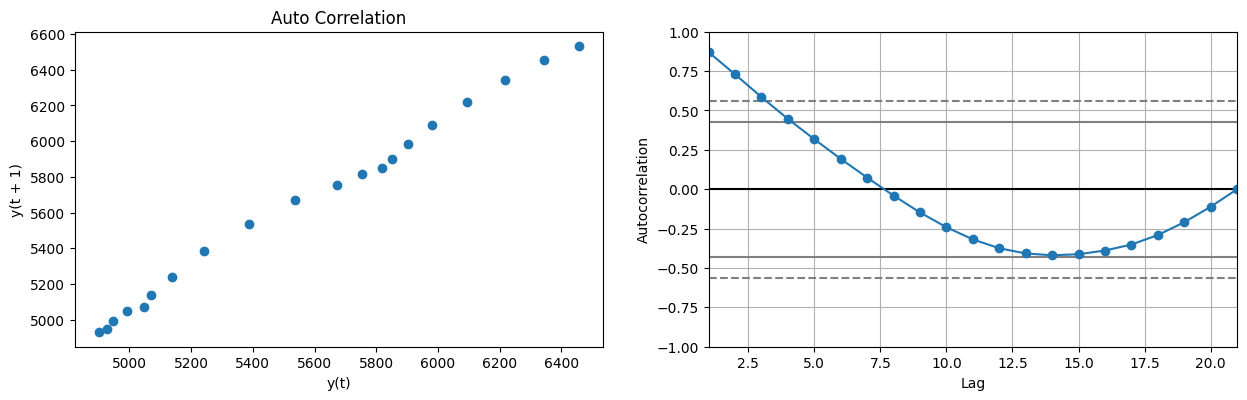

In [157]:
# plot auto correlation
plt.figure(figsize=(15,9))
plt.subplot(221)
lag_plot(example_population)
plt.title('Auto Correlation')

# plot the figure to select lag value
plt.subplot(222)
autocorrelation_plot(example_population, marker='o')
plt.show()

predicted=6099.857937, expected=6093.000000
predicted=6223.776029, expected=6217.000000
predicted=6340.334745, expected=6344.000000
predicted=6448.677423, expected=6457.000000
predicted=6542.497068, expected=6533.000000
Test RMSE: 7.292


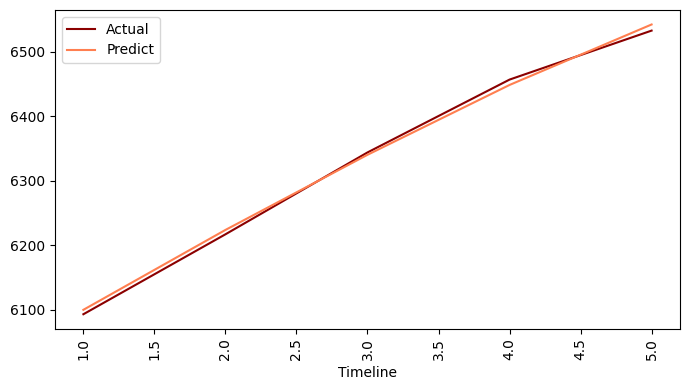

[6099.857937268114,
 6223.7760292911325,
 6340.334744929414,
 6448.677423122254,
 6542.4970680505885]

In [160]:
# use example to fit the model and check model performance
lag_value = 5
test_size = 5
example_result = autoregression_model_pipeline(example_population, test_size, test_size, lag_value)

In [14]:
# get the name of timesteps
population_col = population_data.columns.to_list()
population_pred_col = ['2022_population',
                        '2023_population',
                        '2024_population',
                        '2025_population',
                        '2026_population',
                        '2027_population']
population_col.extend(population_pred_col)

['2001_population',
 '2002_population',
 '2003_population',
 '2004_population',
 '2005_population',
 '2006_population',
 '2007_population',
 '2008_population',
 '2009_population',
 '2010_population',
 '2011_population',
 '2012_population',
 '2013_population',
 '2014_population',
 '2015_population',
 '2016_population',
 '2017_population',
 '2018_population',
 '2019_population',
 '2020_population',
 '2021_population',
 '2022_population',
 '2023_population',
 '2024_population',
 '2025_population',
 '2026_population',
 '2027_population']

predict 5 year population

In [145]:
# train the whole dataset and predict 6 year result
predict_year = 6
test_size = 0
population_result_df = pd.DataFrame()
lag_value = 5

index = 0
while index < len(population_data):

	# fit the model
	predictions = autoregression_model_pipeline(population_data.iloc[index,:], test_size, predict_year, lag_value)

	# append each prediction
	total_value = population_data.iloc[index,:].to_list()
	total_value.extend(predictions)
	
	# change the dimension and save to dataframe
	temp = pd.DataFrame()
	temp = temp.append(total_value).transpose()
	population_result_df = population_result_df.append(temp).reset_index(drop=True)
	index += 1

# set the column name and add sa2 column
population_result_df.columns = population_col
population_result_df['SA2_Code'] = sa2['SA2_Code']
population_result_df['SA2_name'] = sa2['SA2_name']

# save the population data
population_result_df.to_csv('../data/curated/predict_population_AutoReg.csv', index=False)


,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population,SA2_Code,SA2_name
0,5756.0,6092.0,6293.0,6480.0,6648.0,6761.0,7034.0,7272.0,7614.0,7894.0,...,15472.0,16823.0,18293.442531,10449.689320,12670.081190,16753.762513,14867.570969,16691.846376,201011001.0,Alfredton
1,11497.0,11708.0,12015.0,12189.0,12269.0,12356.0,12408.0,12480.0,12476.0,12462.0,...,12183.0,12076.0,12124.089402,12295.589359,12117.828989,12253.951820,12344.222914,12135.034431,201011002.0,Ballarat
2,5320.0,5399.0,5557.0,5620.0,5857.0,6037.0,6131.0,6252.0,6431.0,6595.0,...,7369.0,7232.0,6969.540548,7075.189526,7159.073828,7238.731094,7404.179322,7221.450360,201011005.0,Buninyong
3,4154.0,4225.0,4371.0,4465.0,4704.0,5041.0,5206.0,5349.0,5557.0,5699.0,...,9736.0,10640.0,11750.043245,6016.208099,8687.934139,7879.157795,9838.664100,10711.655405,201011006.0,Delacombe
4,3317.0,3378.0,3411.0,3473.0,3508.0,3542.0,3594.0,3658.0,3714.0,3774.0,...,4148.0,4213.0,4245.208800,3955.595136,3976.601136,4096.482017,4289.499715,4200.888890,201011007.0,Smythes Creek
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,3452.0,3479.0,3511.0,3511.0,3492.0,3459.0,3489.0,3501.0,3490.0,3460.0,...,3905.0,3978.0,4064.713484,3340.680848,3772.033015,3786.931148,3717.887406,4013.963901,217031476.0,Otway
518,6718.0,6704.0,6676.0,6643.0,6638.0,6652.0,6606.0,6631.0,6703.0,6739.0,...,6873.0,6989.0,7095.525912,6496.706799,6763.916302,6672.863098,6985.394690,6955.243564,217041477.0,Moyne - East
519,8317.0,8387.0,8450.0,8487.0,8517.0,8601.0,8694.0,8792.0,8878.0,8965.0,...,9842.0,9963.0,10044.279263,9683.988620,9863.664744,9746.049067,9909.894639,9929.459941,217041478.0,Moyne - West
520,17053.0,17449.0,17726.0,17937.0,18172.0,18528.0,18877.0,19107.0,19369.0,19634.0,...,22379.0,22462.0,22577.284970,21001.307977,22145.047699,21961.816088,22429.423506,22580.149777,217041479.0,Warrnambool - North


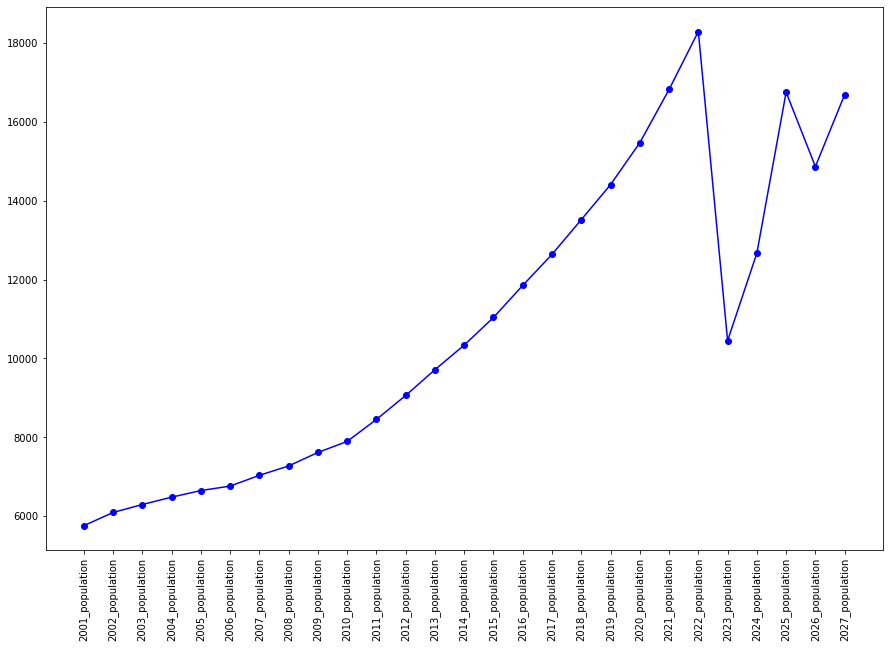

In [162]:
# plot one instance to see the result
plt.figure(figsize=(15,10))
plt.plot(population_col, population_result_df.iloc[0,:27], color='b', marker='o')
plt.xticks(rotation=90)
plt.show()

#### Using linear ols

In [18]:
# find the training time steps
year = []
for i in population_data.columns:
    temp = i.split('_')
    year.append(int(temp[0][-2:]))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [28]:
# use one instance as example to check r-square for the model
INDEX = 0
population_result_df = pd.DataFrame()
population_value = population_data.iloc[INDEX, :].to_list()
predict_year = [22,23,24,25,26,27]

# set the last 6 years data as test data
population_final_df = linear_model_function(year[:-6], population_value[:-6], year[-6:])
result = [population_result_df, population_final_df.transpose()]
population_result_df = pd.concat(result)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     171.0
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           7.40e-09
Time:                        18:03:55   Log-Likelihood:                -111.80
No. Observations:                  15   AIC:                             227.6
Df Residuals:                      13   BIC:                             229.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4959.1333    243.672     20.352      0.0

In [33]:
# The mean squared error
rmse = np.sqrt(mean_squared_error(population_result_df.iloc[1, -6:].copy(), population_value[-6:]))
print("Train RMSE is: ", rmse)

Train RMSE is:  2887.208618968227


In [ ]:
# train all population and predict future population for each region
population_result_df = pd.DataFrame()
for index in range(len(population_data)):
    population_value = population_data.iloc[index, :].to_list()

    # fit the linear model
    population_final_df = linear_model_function(year, population_value, predict_year)
    result = [population_result_df, population_final_df.transpose()]
    population_result_df = pd.concat(result)

In [39]:
# adjust the total output and store as csv
population_result_df = population_result_df.loc['Y', :].copy()
population_result_df.columns = population_col
population_result_df = population_result_df.reset_index(drop=True)
population_result_df['SA2_Code'] = sa2['SA2_Code']
population_result_df['SA2_name'] = sa2['SA2_name']
population_result_df.to_csv('../data/curated/predicted_population_ols.csv', index=False)


### Predict income

##### Using simple linear regression OLS  

In [4]:
# read income data and split
income = pd.read_csv('../data/curated/income.csv')
income_data = income.loc[:, '2014-15_median_income': '2018-19_median_income'].copy()
sa2 = income[['SA2_Code', 'SA2_name']].copy()

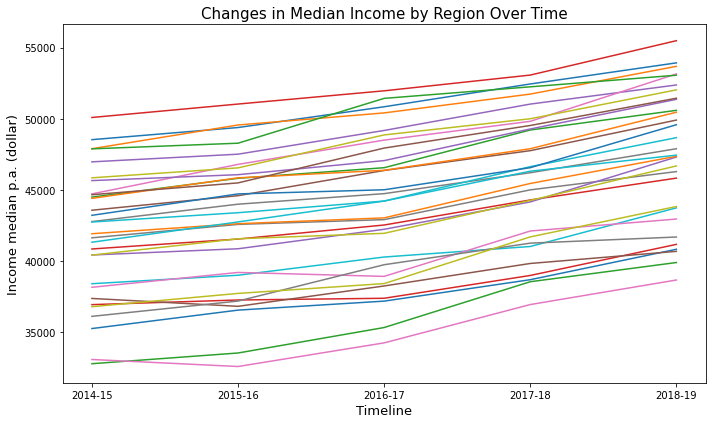

In [28]:
# choose 30 place to show the income changes
EXAMPLE_SIZE = 30
plt.figure(figsize=(10,6))
for i in range(EXAMPLE_SIZE):
    plt.plot(income_data.columns.str.slice(stop=7).to_list(), income_data.iloc[i,:].copy())
plt.title('Changes in Median Income by Region Over Time', fontsize = 15)
plt.xlabel('Timeline', fontsize = 13)
plt.ylabel('Income median p.a. (dollar)', fontsize = 13)
plt.tight_layout()
plt.savefig('../plots/income_history.png')
plt.show()

In [7]:
# extract the time steps
income_timestep = income_data.columns.to_list()

d:\Python39\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     43.56
Date:                Sun, 09 Oct 2022   Prob (F-statistic):             0.0957
Time:                        17:34:45   Log-Likelihood:                -19.147
No. Observations:                   3   AIC:                             42.29
Df Residuals:                       1   BIC:                             40.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.224e+04   2632.278     12.248      0.0

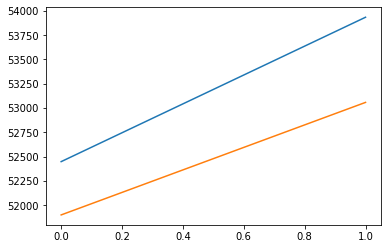

In [48]:
# use one instance as example to check r-square for the model
INDEX = 0
income_result_df = pd.DataFrame()
income_value = income_data.iloc[INDEX, :].to_list()
income_train_year = [i for i in range(14, 17)]
income_predict_year = [i for i in range(17, 19)]

# set the first 3 years data as train data 
income_final_df = linear_model_function(income_train_year, income_value[:3], income_predict_year)
result = [income_result_df, income_final_df.transpose()]
income_result_df = pd.concat(result)


In [19]:
# train all historical income and predict future income for each region
income_result_df = pd.DataFrame()
for index in range(len(income_data)):
    income_value = income_data.iloc[index, :].to_list()
    income_train_year = [i for i in range(14, 19)]
    income_predict_year = [i for i in range(19, 28)]

    # fit the linear model
    income_final_df = linear_model_function(income_train_year, income_value, income_predict_year)
    result = [income_result_df, income_final_df.transpose()]
    income_result_df = pd.concat(result)

In [9]:
# add prediction time steps
for i in range(19, 28):
    income_timestep.append(f'20{i}-{i+1}_median_income')

In [20]:
# adjust the total output and store as csv
income_result_df = income_result_df.loc['Y', :].copy()
income_result_df.columns = income_timestep
income_result_df = income_result_df.reset_index(drop=True)
income_result_df['SA2_Code'] = sa2['SA2_Code']
income_result_df['SA2_name'] = sa2['SA2_name']
income_result_df.to_csv('../data/curated/predict_income_ols.csv', index=False)


,2014-15_median_income,2015-16_median_income,2016-17_median_income,2017-18_median_income,2018-19_median_income,2019-20_median_income,2020-21_median_income,2021-22_median_income,2022-23_median_income,2023-24_median_income,2024-25_median_income,2025-26_median_income,2026-27_median_income,2027-28_median_income,SA2_Code,SA2_name
0,48532.0,49385.0,50845.0,52448.0,53932.0,55187.3,56573.6,57959.9,59346.2,60732.5,62118.8,63505.1,64891.4,66277.7,201011001,Alfredton
1,47894.0,49564.0,50413.0,51736.0,53688.0,54787.0,56163.0,57539.0,58915.0,60291.0,61667.0,63043.0,64419.0,65795.0,201011002,Ballarat
2,44494.0,45816.0,46561.0,49211.0,50593.0,52012.9,53572.2,55131.5,56690.8,58250.1,59809.4,61368.7,62928.0,64487.3,201011003,Ballarat - North
3,40846.0,41544.0,42531.0,44293.0,45828.0,46822.3,48093.6,49364.9,50636.2,51907.5,53178.8,54450.1,55721.4,56992.7,201011004,Ballarat - South
4,46972.0,47511.0,49179.0,51034.0,52377.0,53714.5,55147.8,56581.1,58014.4,59447.7,60881.0,62314.3,63747.6,65180.9,201011005,Buninyong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,31322.0,33020.0,32563.0,33929.0,36219.0,36621.5,37691.8,38762.1,39832.4,40902.7,41973.0,43043.3,44113.6,45183.9,217031476,Otway
458,40775.0,40053.0,41244.0,44000.0,46071.0,46790.3,48244.2,49698.1,51152.0,52605.9,54059.8,55513.7,56967.6,58421.5,217041477,Moyne - East
459,39961.0,41751.0,42159.0,43136.0,45256.0,46045.1,47242.6,48440.1,49637.6,50835.1,52032.6,53230.1,54427.6,55625.1,217041478,Moyne - West
460,42635.0,43536.0,44772.0,46945.0,48855.0,50103.3,51688.2,53273.1,54858.0,56442.9,58027.8,59612.7,61197.6,62782.5,217041479,Warrnambool - North


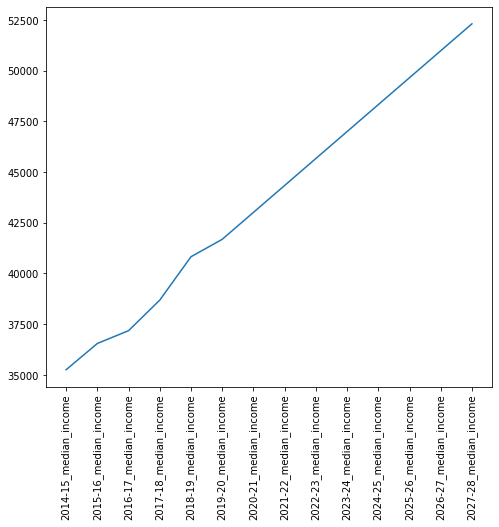

In [12]:
# plot one instance and show the result
plt.figure(figsize=(8,7))
plt.plot(income_result_df.iloc[10, :14])
plt.xticks(rotation=90)
plt.show()

### Predict house price

In [40]:
# read the house price data and extract the place feature
house_price_data = pd.read_csv('../data/curated/house_price.csv')
locality = house_price_data['locality']

In [41]:
# fill the missing value as 0 in dataset to keep the authenticity of data
house_price_data = house_price_data.replace('', 0)
house_price_data = house_price_data.replace('-', 0)
house_price_data =  house_price_data.replace(np.nan, 0)

# extract the data for modelling
price_median = ['2010 Median', '2011 Median', '2012 Median', '2013 Median',
                '2014 Median', '2015 Median', '2016 Median', '2017 Median',
                '2018 Median', '2019 Median', '2020 Median']
train_median_price = house_price_data[price_median]

#### auto reg

use example to check the performance of model

In [47]:
example_house = train_median_price.iloc[10,:].astype('int').copy()

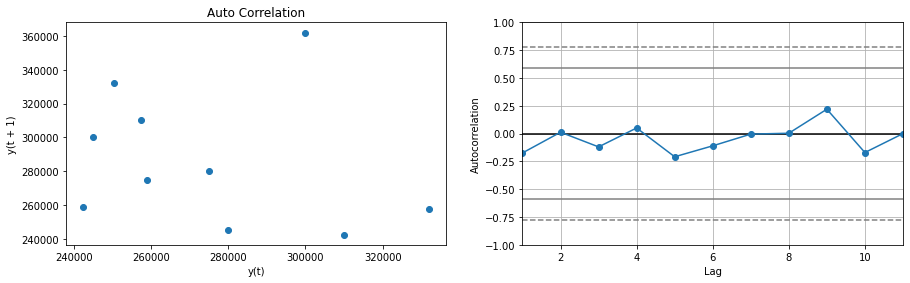

In [48]:
# plot auto correlation
plt.figure(figsize=(15,9))
plt.subplot(221)
lag_plot(example_house)
plt.title('Auto Correlation')

# plot the figure to select lag value
plt.subplot(222)
autocorrelation_plot(example_house, marker='o')
plt.show()

predicted=270603.629161, expected=280000.000000
predicted=268869.370352, expected=245000.000000
predicted=281009.182012, expected=300000.000000
predicted=261932.335118, expected=362000.000000
Test RMSE: 52517.205


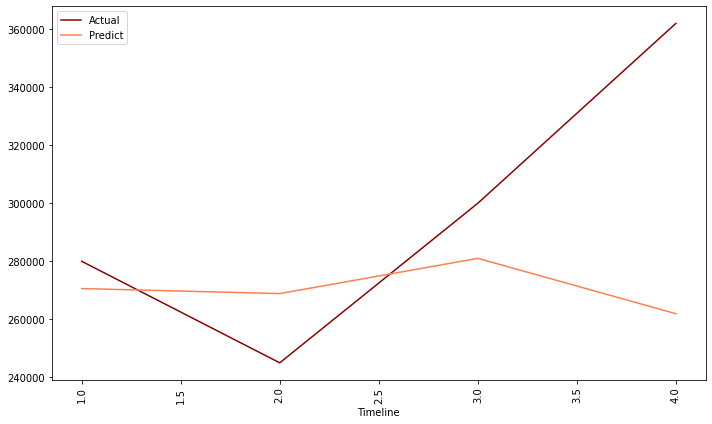

In [49]:
# use example to fit the model and check model performance
lag_value = 1
test_size = 4
example_result = autoregression_model_pipeline(example_house, test_size, test_size, lag_value)

In [30]:
# generate the column name
house_col = train_median_price.columns.to_list()
house_pred_col = ['2021 Median',
                    '2022 Median',
                    '2023 Median',
                    '2024 Median',
                    '2025 Median',
                    '2026 Median',
                    '2027 Median']
house_col.extend(house_pred_col)

In [ ]:
# train the whole dataset and predict 7 year result
HOUSE_PREDICT_YEAR = 7
house_result_df = pd.DataFrame()
lag_value = 2

index = 0
while index < len(train_median_price):

	# fit the model
	predictions = autoregression_model_pipeline(train_median_price.iloc[index,:].astype('int'), 0, HOUSE_PREDICT_YEAR, lag_value)

	# append each prediction
	total_value = train_median_price.iloc[index,:].astype('int').copy().to_list()
	total_value.extend(predictions)
	
	# change the dimension and save to dataframe
	temp = pd.DataFrame()
	temp = temp.append(total_value).transpose()
	house_result_df = house_result_df.append(temp).reset_index(drop=True)
	index += 1

# set the column name and add locality column
house_result_df.columns = house_col
house_result_df['locality'] = locality

# save the population data
house_result_df.to_csv('../data/curated/predict_house_price_AutoReg.csv', index=False)

#### ols

In [ ]:
# predict house median price by ols
predict_median_price = pd.DataFrame()
for index in range(len(train_median_price)):
    median_price_value = train_median_price.iloc[index, :].astype('float').copy().to_list()
    median_price_train_year = [i for i in range(10, 21)]
    median_price_predict_year = [i for i in range(21, 28)]

    # fit the model
    median_final_df = linear_model_function(median_price_train_year, median_price_value, median_price_predict_year)
    result = [predict_median_price, median_final_df.transpose()]
    predict_median_price = pd.concat(result)

In [45]:
# form the timeline for both historical data and predictions
median_price_timeline = []
for i in range(10, 28):
    median_price_timeline.append(f'20{i}_median')

In [46]:
# adjust the final output and save the data
predict_median_price = predict_median_price.loc['Y', :].copy()
predict_median_price.columns = median_price_timeline
predict_median_price['locality'] = house_price_data['locality'].tolist()
predict_median_price.to_csv('../data/curated/predict_house_price_median.csv', index=False)

### Predict rental median

In [6]:
# read the history rental median data
rental_median_data = pd.read_csv('../data/curated/rental_median.csv')

# extract the total median data and fill missing data as 0
column_names = []
for i in rental_median_data.columns:
    if 'total' in i and 'b' not in i:
        column_names.append(i)
rental_data = rental_median_data[column_names]
rental_data = rental_data.replace('-', 0)

use example to check the performance of model

In [10]:
INDEX_RENTAL = 5
example_rental = rental_data.loc[INDEX_RENTAL]

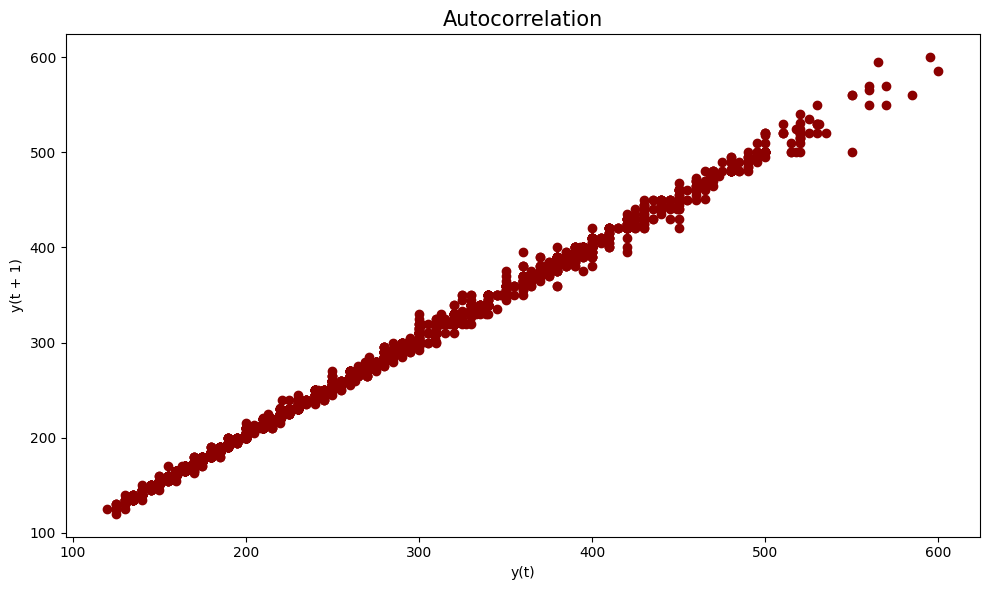

In [132]:
# use frist 30 places data as example to observe the autocorrelation
plt.style.use('default')
fig, ax = plt.subplots(figsize = (10,6))
for i in range(EXAMPLE_SIZE):
    lag_plot(rental_data.loc[i].astype('int'), c='darkred', ax =ax)
plt.title('Autocorrelation', fontsize=15)
plt.tight_layout()
plt.savefig('../plots/t_t+1_corr.png')
plt.show()


the auto-correlation shows a strong correlation between current time step and next time step

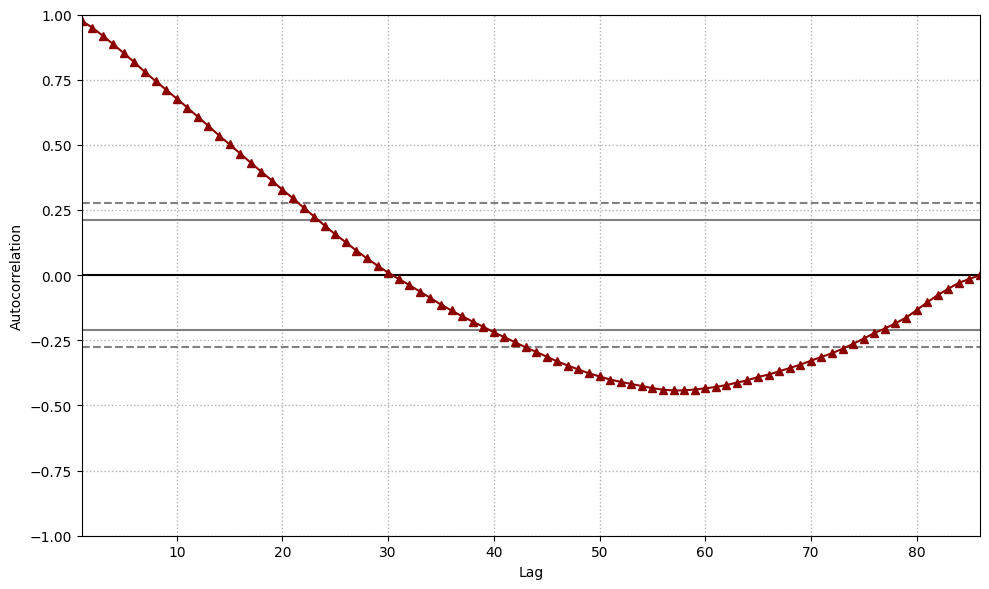

In [145]:
# plot the autocorrelation plot and select the lag value
fig, ax = plt.subplots(figsize = (10,6))
autocorrelation_plot(example_rental.astype('int'), c='darkred', marker='^')
ax.grid(linestyle=':', linewidth=1)
plt.tight_layout()
plt.savefig('../plots/autocorrelation.png')
plt.show()


predicted=504.470526, expected=520.000000
predicted=518.490657, expected=520.000000
predicted=509.813542, expected=520.000000
predicted=523.013516, expected=531.000000
predicted=535.534171, expected=530.000000
predicted=526.831376, expected=530.000000
predicted=544.668779, expected=550.000000
predicted=547.698296, expected=560.000000
predicted=550.590331, expected=570.000000
predicted=570.162774, expected=570.000000
predicted=557.243618, expected=550.000000
predicted=559.473550, expected=560.000000
predicted=550.834246, expected=565.000000
predicted=569.693596, expected=595.000000
predicted=584.985742, expected=600.000000
predicted=590.406520, expected=585.000000
predicted=583.820727, expected=560.000000
predicted=558.669491, expected=550.000000
predicted=554.323660, expected=500.000000
predicted=523.706149, expected=500.000000
Test RMSE: 17.766


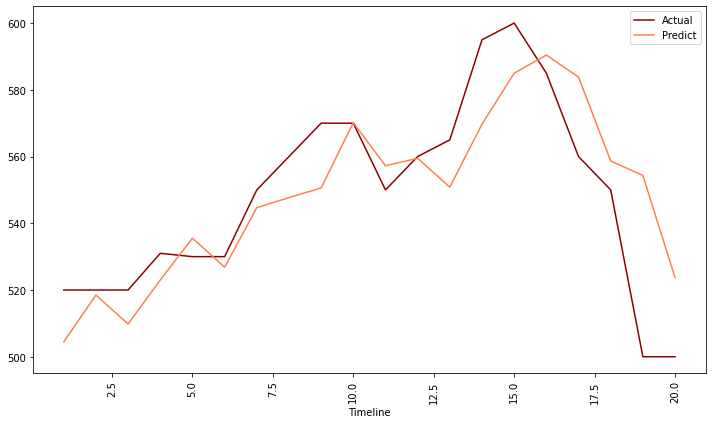

In [50]:
# use one instance as example to check the RMSE for model performance
lag_value = 23
predict_size = 20
example_result = autoregression_model_pipeline(example_rental.astype('float'), predict_size, predict_size, lag_value)

In [176]:
# generate the column name for rental timeline
rental_pred_name = ['Sep_2021', 'Dec_2021',
					'Mar_2022', 'Jun_2022', 'Sep_2022', 'Dec_2022',
					'Mar_2023', 'Jun_2023', 'Sep_2023', 'Dec_2023',
					'Mar_2024', 'Jun_2024', 'Sep_2024', 'Dec_2024',
					'Mar_2025', 'Jun_2025', 'Sep_2025', 'Dec_2025',
					'Mar_2026', 'Jun_2026', 'Sep_2026', 'Dec_2026',
					'Mar_2027', 'Jun_2027', 'Sep_2027', 'Dec_2027']
rental_col = rental_data.columns.str.slice(start=13).to_list()
rental_col.extend(rental_pred_name)

In [177]:
# train the whole dataset and predict 26 quarter result
PREDICT_LEN = 26
result_df = pd.DataFrame()
lag_value = 23

index = 0
while index < len(rental_data):

	# fit the model
	predictions = autoregression_model_pipeline(rental_data.iloc[index,:].astype('float'), 0, PREDICT_LEN, lag_value)
	
	# append each prediction
	total_value = rental_data.astype('float').iloc[index,:].to_list()
	total_value.extend(predictions)
	
	# change the dimension and save to dataframe
	temp = pd.DataFrame()
	temp = temp.append(total_value).transpose()
	result_df = result_df.append(temp).reset_index(drop=True)
	index += 1

# set the column name and add suburb column
result_df.columns = rental_col
result_df['suburb'] = rental_median_data['suburb']

# save the rental median data
result_df.to_csv('../data/curated/predict_rental_AutoReg.csv', index=False)


,Mar_2000,Jun_2000,Sep_2000,Dec_2000,Mar_2001,Jun_2001,Sep_2001,Dec_2001,Mar_2002,Jun_2002,...,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027,suburb
0,175.0,180.0,180.0,180.0,180.0,185.0,190.0,195.0,200.0,200.0,...,472.206287,516.491418,474.643085,485.864002,503.440168,483.912978,488.385414,483.911503,484.547703,YARRAVILLE
1,145.0,145.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,155.0,...,328.045832,324.923760,334.097642,335.553168,336.187029,353.675407,331.858821,335.758787,345.086805,WODONGA
2,220.0,225.0,230.0,240.0,245.0,240.0,245.0,250.0,250.0,260.0,...,438.240129,445.039466,455.011112,461.676035,455.996250,450.615165,445.272220,429.647564,424.114145,WINDSOR
3,240.0,240.0,240.0,240.0,250.0,255.0,260.0,263.0,263.0,260.0,...,521.912354,513.685696,519.226838,530.134806,538.373845,530.141439,518.984886,510.934268,501.058677,WILLIAMSTOWN
4,150.0,150.0,155.0,170.0,163.0,170.0,165.0,170.0,175.0,180.0,...,389.291592,385.097303,378.192172,392.668803,401.616743,386.659778,392.091374,390.410736,389.379426,WHITTLESEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,165.0,170.0,170.0,170.0,175.0,175.0,175.0,180.0,180.0,180.0,...,389.224616,405.742677,401.707094,410.379378,392.548879,400.250469,399.943881,398.669316,402.603799,ALTONA
209,150.0,146.0,150.0,155.0,160.0,165.0,165.0,170.0,175.0,180.0,...,446.551272,463.081245,452.227812,458.693335,444.162921,423.936817,418.731264,412.183752,404.822325,ALPHINGTON
210,130.0,135.0,135.0,135.0,140.0,140.0,140.0,150.0,150.0,155.0,...,336.300762,337.586171,330.403965,353.111456,334.664872,342.352293,344.650800,351.063770,358.018183,ALFREDTON
211,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,300.0,300.0,...,549.904660,546.836880,570.225829,592.002128,594.825665,565.493326,550.246053,532.124745,506.714078,ALBERT PARK


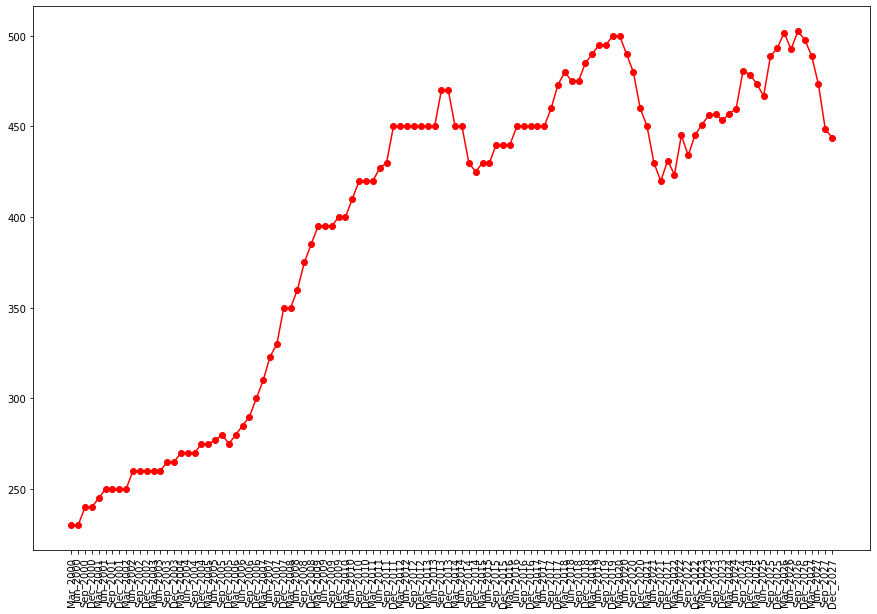

In [178]:
# plot an instance to show the result
plt.figure(figsize=(15,10))
plt.plot(rental_col, result_df.iloc[INDEX_RENTAL], color='red', marker='o')
plt.xticks(rotation=90)
plt.show()